# Create db from scraped data

## Imports

In [1]:
import glob
import json
import re

import networkx as nx
from itertools import combinations

## Read raw API call files

Reads all the stored API call files and compiles them into a more useful DataFrame.

In [2]:
user_map = {}
transaction_map = {}

for f_name in tqdm(glob.glob('data/raw/*.json')):
    with open(f_name, 'r') as f:
        data = json.load(f)
        for entry in data['data']:
            actor = entry['actor']
            
            assert(len(entry['transactions']) == 1)
            transaction = entry['transactions'][0]
            target = transaction['target']
            if (target in ['a phone number', 'an email', None] or
                target.get('name') == 'a user on iMessage'):
                continue
            
            # custom entries
            entry['from'] = int(actor['id'])
            entry['to'] = int(target['id'])

            user_map[int(actor['id'])] = actor
            user_map[int(target['id'])] = target
            transaction_map[entry['story_id']] = entry

NameError: name 'tqdm' is not defined

In [19]:
crawled_files = glob.glob('data/raw/*.json')
crawled_users = set([int(re.match('data/raw/([0-9]*)-[0-9]{3}[.]json', fname).groups()[0]) 
                     for fname in crawled_files])
del crawled_files

In [20]:
transactions = pd.DataFrame().from_dict(transaction_map, orient='index')[[
     'created_time',
     'from',
     'to',
     'message',
     'type',
     'payment_id',
     'permalink',
     'via',
     'story_id',
     'updated_time',
     'audience',
]]
transactions['created_time'] = pd.to_datetime(transactions.created_time)
transactions['updated_time'] = pd.to_datetime(transactions.updated_time)

users = pd.DataFrame().from_dict(user_map, orient='index')[[
    'username',
     'name',
     'firstname',
     'lastname',
     'date_created',
     'cancelled',
     'external_id',
     'is_business',
     'picture',
]]
users['date_created'] = pd.to_datetime(users.date_created)

users.loc[crawled_users,'is_crawled'] = True
users.is_crawled.fillna(False, inplace=True)

transactions.to_csv('data/processed/transactions.csv', index_label='Id')
users.to_csv('data/processed/users.csv', index_label='Id')

## Figure out new IDs to crawl

In [21]:
harvard_names = pd.concat([pd.read_csv(f) for f in glob.glob('data/harvard/*.csv')],
                          sort=False) \
    .reset_index(drop=True)

In [22]:
harvard_names['name'] = harvard_names['First Name'] + ' ' + harvard_names['Last Name']

In [23]:
len(harvard_names)

4681

In [24]:
len(harvard_names.name.unique())

4659

In [25]:
len(users.query('is_crawled').name.unique())

3571

In [26]:
len(crawled_users)

3926

In [37]:
len(transactions)

381613

In [27]:
prominence = transactions.groupby('from').size().add(transactions.groupby('to').size(), fill_value=0)

In [28]:
to_crawl = users.loc[list(prominence[users.name.isin(harvard_names.name) & 
                       (~prominence.index.isin(crawled_users))]
    .sort_values(ascending=False).index),:]

In [29]:
to_crawl_ids = list(to_crawl.index)

Store this list of values to crawl to hand off to the crawling notebook.

In [30]:
%store to_crawl_ids

Stored 'to_crawl_ids' (list)


In [31]:
len(to_crawl)

212

In [33]:
len(to_crawl.name.unique())

133

In [428]:
len(harvard_names)

3379

## Inspect and play around with the data

[]

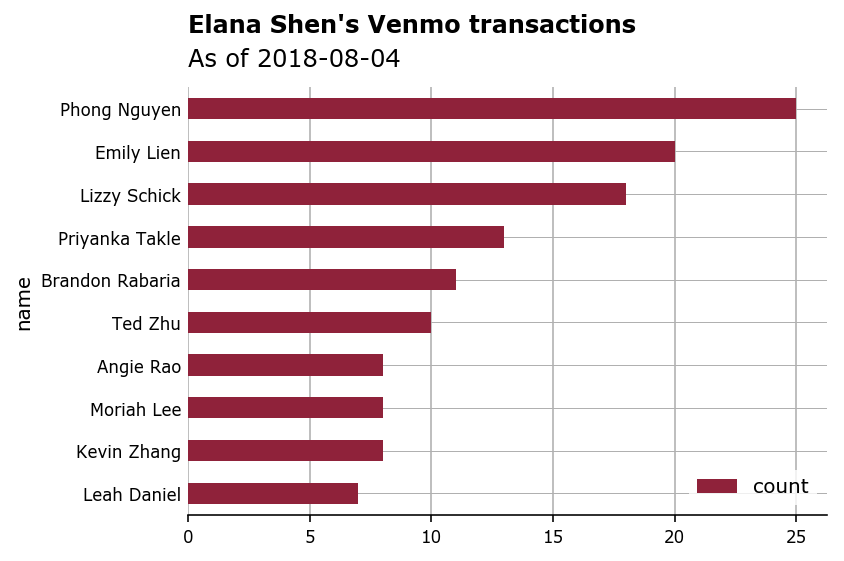

In [75]:
name = 'Elana Shen'
u_id = users[users.name == name].index[0]
user_transacts = transactions[(transactions['from'] == u_id) | 
                              (transactions.to == u_id)]

counts = (user_transacts['from']
    .where(user_transacts['from'] != u_id, user_transacts.to)
    .to_frame('other')
    .groupby('other')
    .size())

(pd.concat([counts.to_frame('count'), users.name], axis=1)
    .sort_values('count', ascending=True)
    .dropna()
    .set_index('name')
    .iloc[-10:]
    .plot
    .barh())

plt.grid()
plt.legend()
ft_ax(title="%s's Venmo transactions" % name, subtitle='As of 2018-08-04', y=1.1, left_axis=True)

In [76]:
user_transacts\
.merge(users.loc[:,['name']], left_on='from', right_index=True) \
.rename(columns={'name': 'from_name'}) \
.merge(users.loc[:,['name']], left_on='to', right_index=True) \
.rename(columns={'name': 'to_name'}) \
.loc[:,['created_time', 'message', 'from_name', 'to_name']]

,created_time,message,from_name,to_name
56d8b7dbcd03c9af22178511,2016-03-03 22:16:59,keychange🔑,Elana Shen,Gen Lefevre
56da498fcd03c9af2234ba8b,2016-03-05 02:50:55,pizza pizza 🍕,Elana Shen,Leah Daniel
570d775bcd03c9af228f366e,2016-04-12 22:31:55,♻️🚯☃🔮🕳↪️🔀,Elana Shen,Leah Daniel
572d54d6cd03c9af22d62462,2016-05-07 02:37:10,love and friendship,Elana Shen,Leah Daniel
573325c6cd03c9af22382524,2016-05-11 12:29:58,tissues,Elana Shen,Leah Daniel
589ff48723e064eac05e01e1,2017-02-12 05:37:11,cookie cream,Elana Shen,Leah Daniel
59121002a385c7e9b5f12288,2017-05-09 18:52:50,stunted,Elana Shen,Leah Daniel
56f9913dcd03c9af22274735,2016-03-28 20:17:01,🎫,Elana Shen,Harvard Korean Association
572815a9cd03c9af227385a0,2016-05-03 03:06:17,formal,Elana Shen,Kirkland HoCo
576610d8cd03c9af22adb8a3,2016-06-19 03:26:16,hanging out without @phong1,Elana Shen,Angie Rao
